In [1]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import numpy
import random
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

In [2]:
# 生成两个数据集，各有200个数据，X^1是维度为2，X^2维度为10，其中每个数据中前100个标签为0，后100个标签为1。
X1, y1 = make_moons(200, noise=0.2, shuffle=False, random_state=7)
X2, y2 = make_blobs(n_samples=200, n_features=10, shuffle=False, centers=2, center_box=(-10, 10), random_state=7)

# 对两个数据集进行降维，用KMeans，聚为两类
km1 = KMeans(n_clusters=2, random_state=0)
km2 = KMeans(n_clusters=2, random_state=0)
a1 = km1.fit(X1)
a2 = km2.fit(X2)

# 这是每个聚类的中心
X1_center_1 = km1.cluster_centers_[0, :]
X1_center_2 = km1.cluster_centers_[1, :]
X2_center_1 = km2.cluster_centers_[0, :]
X2_center_2 = km2.cluster_centers_[1, :]

# 用聚类后每个点到聚类中心的欧式距离来算出属于某聚类的概率，从而生成A矩阵
def create_A_matrix(X, center1, center2):
    A = np.zeros((200, 2))

    for i in range(200):
        dis1 = np.sqrt(np.sum(np.square(X[i, :] - center1)))
        dis2 = np.sqrt(np.sum(np.square(X[i, :] - center2)))
        A[i, 0] = dis1 / (dis1 + dis2)
        A[i, 1] = dis2 / (dis1 + dis2)

    return A

# 生成A矩阵
A1 = np.mat(create_A_matrix(X1, X1_center_1, X1_center_2))
A2 = np.mat(create_A_matrix(X2, X2_center_1, X2_center_2))

#将矩阵变为tensor
X1 = torch.from_numpy(X1).double()
X2 = torch.from_numpy(X2).double()
A1 = torch.from_numpy(A1).double()
A2 = torch.from_numpy(A2).double()

y = y1

In [3]:
#搭建感知机网络
class MlpNet(nn.Module):
    def __init__(self, layer_sizes, input_size):
        super(MlpNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + layer_sizes
        for l_id in range(len(layer_sizes) - 1):
            if l_id == len(layer_sizes) - 2:
                layers.append(nn.Sequential(
                    nn.BatchNorm1d(num_features=layer_sizes[l_id], affine=False, track_running_stats=True),
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                ))
            else:
                layers.append(nn.Sequential(
                    nn.Linear(layer_sizes[l_id], layer_sizes[l_id + 1]),
                    nn.Sigmoid(),
                    nn.BatchNorm1d(num_features=layer_sizes[l_id + 1], affine=False, track_running_stats=True),
                ))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
#搭建深度模型
class DeepCCA(nn.Module):
    def __init__(self, layer_sizes1, layer_sizes2, input_size1, input_size2, outdim_size, use_all_singular_values, device=torch.device('cpu')):
        super(DeepCCA, self).__init__()
        self.model1 = MlpNet(layer_sizes1, input_size1).double()
        self.model2 = MlpNet(layer_sizes2, input_size2).double()

        self.loss = cca_loss(outdim_size, use_all_singular_values, device).loss

    def forward(self, x1, x2):
        # feature * batch_size
        output1 = self.model1(x1)
        output2 = self.model2(x2)

        return output1, output2

In [5]:
#Loss(Corr)
class cca_loss():
    def __init__(self, outdim_size, use_all_singular_values, device):
        self.outdim_size = outdim_size
        self.use_all_singular_values = use_all_singular_values
        self.device = device
        print(device)

    def loss(self, H1, H2):

        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9

        H1, H2 = H1.t(), H2.t()
        o1 = o2 = H1.size(0)

        m = H1.size(1)

        H1bar = H1 - H1.mean(dim=1).unsqueeze(dim=1)
        H2bar = H2 - H2.mean(dim=1).unsqueeze(dim=1)


        SigmaHat12 = (1.0 / (m - 1)) * torch.mm(H1bar, H2bar.t())
        SigmaHat11 = (1.0 / (m - 1)) * torch.mm(H1bar, H1bar.t()) + r1 * torch.eye(o1, device=self.device)
        SigmaHat22 = (1.0 / (m - 1)) * torch.mm(H2bar, H2bar.t()) + r2 * torch.eye(o2, device=self.device)
     
        [D1, V1] = torch.symeig(SigmaHat11, eigenvectors=True)
        [D2, V2] = torch.symeig(SigmaHat22, eigenvectors=True)
     
        # Added to increase stability
        posInd1 = torch.gt(D1, eps).nonzero()[:, 0]
        D1 = D1[posInd1]
        V1 = V1[:, posInd1]
        posInd2 = torch.gt(D2, eps).nonzero()[:, 0]
        D2 = D2[posInd2]
        V2 = V2[:, posInd2]

        SigmaHat11RootInv = torch.mm(torch.mm(V1, torch.diag(D1 ** -0.5)), V1.t())
        SigmaHat22RootInv = torch.mm(torch.mm(V2, torch.diag(D2 ** -0.5)), V2.t())

        Tval = torch.mm(torch.mm(SigmaHat11RootInv,
                                         SigmaHat12), SigmaHat22RootInv)


        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = torch.mm(Tval.t(), Tval)
            corr = torch.trace(torch.sqrt(tmp))
            # assert torch.isnan(corr).item() == 0
        else:
            # just the top self.outdim_size singular values are used
            trace_TT = torch.mm(Tval.t(), Tval)
            trace_TT = torch.add(trace_TT, (torch.eye(trace_TT.shape[0])*r1).to(self.device)) # regularization for more stability
            U, V = torch.symeig(trace_TT, eigenvectors=True)
            U = torch.where(U>eps, U, (torch.ones(U.shape).double()*eps).to(self.device))
            U = U.topk(self.outdim_size)[0]
            corr = torch.sum(torch.sqrt(U))



        return -corr

In [6]:
class Solver():
    def __init__(self, model, outdim_size, epoch_num, learning_rate, reg_par,
                 device=torch.device('cpu')):
        self.model = nn.DataParallel(model)
        self.model.to(device)
        self.epoch_num = epoch_num
        self.loss = model.loss
        self.optimizer = torch.optim.RMSprop(
            self.model.parameters(), lr=learning_rate, weight_decay=reg_par)
        self.device = device
        self.outdim_size = outdim_size


    def fit(self, x1, x2, tst1 = None, tst2 = None):
        
        x1.to(self.device)
        x2.to(self.device)
        
        if tst1 is not None and tst2 is not None:
            tst1.to(self.device)
            tst2.to(self.device)

        train_losses = []
        for epoch in range(self.epoch_num):
            self.model.train()
            self.optimizer.zero_grad()
            batch_x1 = x1
            batch_x2 = x2
            o1, o2 = self.model(batch_x1, batch_x2)
            loss = self.loss(o1, o2)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            train_loss = np.mean(train_losses)
            print('Epoch:', epoch + 1, '    Loss:', train_loss)
            if epoch % 100 == 0:
                o1_ = o1.cpu().detach().numpy()
                o2_ = o2.cpu().detach().numpy()
                #visualization_LR(o1_, y, 'View 1')
                #visualization_LR(o2_, y, 'View 2')


    def test(self, x1, x2, use_linear_cca=False):
        with torch.no_grad():
            
            self.model.eval()
            losses = []
            outputs1 = []
            outputs2 = []
            o1, o2 = self.model(x1, x2)
            outputs1.append(o1)
            outputs2.append(o2)
            loss = self.loss(o1,o2)
            losses.append(loss.item())

        outputs = [torch.cat(outputs1, dim=0).cpu().numpy(),
                   torch.cat(outputs2, dim=0).cpu().numpy()]
        return losses, outputs
        
            

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#精确度分析
def acc(y_pred, y_true):
    return accuracy_score(y_true, y_pred, normalize=True)

# 线性分类器
def LR(X_train, y_train, y_test=None):
    clf = LogisticRegression(penalty='l2')
    clf.fit(X_train, y_train)  
    return clf.coef_, clf.intercept_, clf.predict(X_train)

#预留20%为测试集，在测试集上的精度
def LR_2(Train_x, Train_y):
    train_x, test_x, train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.2, random_state=2)
    clf1 = LogisticRegression(penalty='l2')
    clf1.fit(train_x, train_y)
    pred_y = clf1.predict(test_x)
    acc = accuracy_score(test_y, pred_y, normalize=True)
    fpr, tpr, thresholds = roc_curve(test_y, pred_y, pos_label=1)
    auc_ = auc(fpr, tpr)
    return acc, auc_

#非线性分类器
def svm(X_train, y_train):
    nlc = SVC(kernel='rbf')
    nlc.fit(X_train, y_train)
    return nlc

def svm_2(Train_x, Train_y):
    train_x, test_x, train_y, test_y = train_test_split(Train_x, Train_y, test_size=0.2, random_state=2)
    nlc1 = SVC(kernel='rbf')
    nlc1.fit(train_x, train_y)
    pred_y = nlc1.predict(test_x)
    acc = accuracy_score(test_y, pred_y, normalize=True)
    fpr, tpr, thresholds = roc_curve(test_y, pred_y, pos_label=1)
    auc_ = auc(fpr, tpr)
    return acc, auc_


# 可视化
def visualization_LR(X, y, title):
    weight = LR(X, y)[0]
    bias = LR(X, y)[1]
    dataArr = np.array(X)
    xcord1 = [];
    ycord1 = []
    xcord2 = [];
    ycord2 = []
    for i in range(y.shape[0]):
        if int(y[i]) == 1:
            xcord1.append(dataArr[i, 0]);
            ycord1.append(dataArr[i, 1])
        else:
            xcord2.append(dataArr[i, 0]);
            ycord2.append(dataArr[i, 1])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x_1 = np.arange(-1, 2, 0.01)
    a = -weight[0, 0] / weight[0, 1]
    b = -bias / weight[0, 1]
    #y_1 = a * x_1 + b
    # -weights[0]
    #ax.plot(x_1, y_1)
    plt.title(title)
    plt.show()
    
def visualization_SVM(X, y, title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
    xy = np.vstack([xx.ravel(), yy.ravel()]).T
    Z = svm(X, y).decision_function(xy).reshape(xx.shape)
    #plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max(),), aspect='auto',
               #origin='lower', cmap=plt.cm.PuOr_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyle='-')
    plt.scatter(X[:, 0].tolist(), X[:, 1].tolist(), s=30, c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.title(title)
    plt.show()
    

cpu
Epoch: 1     Loss: -0.7201978224770378
Epoch: 2     Loss: -0.8427655168877166
Epoch: 3     Loss: -0.9011358026001632
Epoch: 4     Loss: -0.9390256105383943
Epoch: 5     Loss: -0.9666786741527458
Epoch: 6     Loss: -0.9876749729156374
Epoch: 7     Loss: -1.0056883693984793
Epoch: 8     Loss: -1.0071254891126609
Epoch: 9     Loss: -1.015432542269809
Epoch: 10     Loss: -1.0240353601095709
Epoch: 11     Loss: -1.0318780137445305
Epoch: 12     Loss: -1.039079973306519
Epoch: 13     Loss: -1.0455972889964686
Epoch: 14     Loss: -1.0520062084173456
Epoch: 15     Loss: -1.0582309154839573
Epoch: 16     Loss: -1.0632401405562948
Epoch: 17     Loss: -1.06864122324968
Epoch: 18     Loss: -1.0726471156388435
Epoch: 19     Loss: -1.0789694300214314
Epoch: 20     Loss: -1.0852248546600392
Epoch: 21     Loss: -1.0902637424003156


D:\Anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:32: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)


Epoch: 22     Loss: -1.0952809247346027
Epoch: 23     Loss: -1.099725519734995
Epoch: 24     Loss: -1.1053892660664015
Epoch: 25     Loss: -1.110259823513311
Epoch: 26     Loss: -1.1150699055644275
Epoch: 27     Loss: -1.1174215119226905
Epoch: 28     Loss: -1.1214098652633182
Epoch: 29     Loss: -1.1258932862636228
Epoch: 30     Loss: -1.1307501569753704
Epoch: 31     Loss: -1.1343661738993598
Epoch: 32     Loss: -1.138497516003491
Epoch: 33     Loss: -1.141028565525673
Epoch: 34     Loss: -1.1431765108983005
Epoch: 35     Loss: -1.144762273476787
Epoch: 36     Loss: -1.1472391641053197
Epoch: 37     Loss: -1.1496390044862044
Epoch: 38     Loss: -1.1517548516357146
Epoch: 39     Loss: -1.1530396830588159
Epoch: 40     Loss: -1.155615603741558
Epoch: 41     Loss: -1.158420197467783
Epoch: 42     Loss: -1.1612107349739886
Epoch: 43     Loss: -1.1639094047974081
Epoch: 44     Loss: -1.165978264136042
Epoch: 45     Loss: -1.1691545362875084
Epoch: 46     Loss: -1.1724085204424342
Epoch: 4

Epoch: 237     Loss: -1.4651819053387443
Epoch: 238     Loss: -1.466053280117299
Epoch: 239     Loss: -1.46693419778102
Epoch: 240     Loss: -1.4677209012021597
Epoch: 241     Loss: -1.4686132207130067
Epoch: 242     Loss: -1.4694955174036066
Epoch: 243     Loss: -1.4703790896098274
Epoch: 244     Loss: -1.4712171887796066
Epoch: 245     Loss: -1.472035341027411
Epoch: 246     Loss: -1.472820380614588
Epoch: 247     Loss: -1.4736351952681062
Epoch: 248     Loss: -1.474353229091482
Epoch: 249     Loss: -1.4750878301420811
Epoch: 250     Loss: -1.4758190598602372
Epoch: 251     Loss: -1.476599546131173
Epoch: 252     Loss: -1.4773085047421821
Epoch: 253     Loss: -1.4779722897869003
Epoch: 254     Loss: -1.4787156233464873
Epoch: 255     Loss: -1.4795276626558804
Epoch: 256     Loss: -1.4803056324327462
Epoch: 257     Loss: -1.4810170906645153
Epoch: 258     Loss: -1.4817821836872922
Epoch: 259     Loss: -1.48256263047127
Epoch: 260     Loss: -1.4833378351691824
Epoch: 261     Loss: -1.4

Epoch: 456     Loss: -1.5857184294225544
Epoch: 457     Loss: -1.5860781585834867
Epoch: 458     Loss: -1.5864589250147803
Epoch: 459     Loss: -1.5868496362484918
Epoch: 460     Loss: -1.5872265510573238
Epoch: 461     Loss: -1.5875951515135878
Epoch: 462     Loss: -1.587959122749261
Epoch: 463     Loss: -1.5883234917187652
Epoch: 464     Loss: -1.5886857863698847
Epoch: 465     Loss: -1.589045389804763
Epoch: 466     Loss: -1.5894083349202541
Epoch: 467     Loss: -1.589772058801693
Epoch: 468     Loss: -1.5901342092269741
Epoch: 469     Loss: -1.5905016903503746
Epoch: 470     Loss: -1.5908659570956056
Epoch: 471     Loss: -1.5912367096931852
Epoch: 472     Loss: -1.5915919885677374
Epoch: 473     Loss: -1.5919615656257207
Epoch: 474     Loss: -1.5922983752842914
Epoch: 475     Loss: -1.592686014308182
Epoch: 476     Loss: -1.5930543655704892
Epoch: 477     Loss: -1.5934086953116946
Epoch: 478     Loss: -1.5937558929480071
Epoch: 479     Loss: -1.5941141830914916
Epoch: 480     Loss:

Epoch: 660     Loss: -1.6472358802256588
Epoch: 661     Loss: -1.6474860874163035
Epoch: 662     Loss: -1.647745884691096
Epoch: 663     Loss: -1.6479990692895312
Epoch: 664     Loss: -1.6482516445003979
Epoch: 665     Loss: -1.6484870688226716
Epoch: 666     Loss: -1.6486984956373836
Epoch: 667     Loss: -1.6489372898552908
Epoch: 668     Loss: -1.6491963865757173
Epoch: 669     Loss: -1.6494476881575058
Epoch: 670     Loss: -1.649694308385193
Epoch: 671     Loss: -1.649926771614663
Epoch: 672     Loss: -1.650175822922495
Epoch: 673     Loss: -1.650421657541571
Epoch: 674     Loss: -1.6506741839910655
Epoch: 675     Loss: -1.6509214437903998
Epoch: 676     Loss: -1.6511699465034322
Epoch: 677     Loss: -1.65140376521923
Epoch: 678     Loss: -1.6516392671521214
Epoch: 679     Loss: -1.6518597991226946
Epoch: 680     Loss: -1.6521032630444161
Epoch: 681     Loss: -1.6523365084365267
Epoch: 682     Loss: -1.6525781520718081
Epoch: 683     Loss: -1.6528111656533875
Epoch: 684     Loss: -1

Epoch: 870     Loss: -1.6916744561822663
Epoch: 871     Loss: -1.6918556063837373
Epoch: 872     Loss: -1.6920314417096765
Epoch: 873     Loss: -1.6922157538670122
Epoch: 874     Loss: -1.692394551575055
Epoch: 875     Loss: -1.692578660371835
Epoch: 876     Loss: -1.6927577698982466
Epoch: 877     Loss: -1.6929415192995059
Epoch: 878     Loss: -1.6931215556126964
Epoch: 879     Loss: -1.6933051518311966
Epoch: 880     Loss: -1.693485208177102
Epoch: 881     Loss: -1.6936718492906484
Epoch: 882     Loss: -1.6938589434478106
Epoch: 883     Loss: -1.6940490114798272
Epoch: 884     Loss: -1.6942360762012398
Epoch: 885     Loss: -1.694424256898049
Epoch: 886     Loss: -1.694603750498513
Epoch: 887     Loss: -1.694787884797857
Epoch: 888     Loss: -1.6949665156986433
Epoch: 889     Loss: -1.6951549709829867
Epoch: 890     Loss: -1.6953402186811497
Epoch: 891     Loss: -1.6955265669287973
Epoch: 892     Loss: -1.6957055972031048
Epoch: 893     Loss: -1.695884486888844
Epoch: 894     Loss: -1

Epoch: 1078     Loss: -1.7251864093478964
Epoch: 1079     Loss: -1.7253348274206322
Epoch: 1080     Loss: -1.725478281227124
Epoch: 1081     Loss: -1.7256241111515769
Epoch: 1082     Loss: -1.725766317480244
Epoch: 1083     Loss: -1.7259127851499705
Epoch: 1084     Loss: -1.7260586607721848
Epoch: 1085     Loss: -1.726208169534482
Epoch: 1086     Loss: -1.7263535056647281
Epoch: 1087     Loss: -1.7264991385621804
Epoch: 1088     Loss: -1.7266438512698472
Epoch: 1089     Loss: -1.726790081770068
Epoch: 1090     Loss: -1.7269322325385181
Epoch: 1091     Loss: -1.727076837445426
Epoch: 1092     Loss: -1.7272195806846813
Epoch: 1093     Loss: -1.7273629340485415
Epoch: 1094     Loss: -1.7275059098350882
Epoch: 1095     Loss: -1.7276481761332252
Epoch: 1096     Loss: -1.7277877185456845
Epoch: 1097     Loss: -1.7279210130060727
Epoch: 1098     Loss: -1.7280548953611992
Epoch: 1099     Loss: -1.72818411579971
Epoch: 1100     Loss: -1.728318914034983
Epoch: 1101     Loss: -1.7284497823973242


Epoch: 1278     Loss: -1.7512356309700148
Epoch: 1279     Loss: -1.7513495227985671
Epoch: 1280     Loss: -1.7514648624378837
Epoch: 1281     Loss: -1.7515754112395545
Epoch: 1282     Loss: -1.751691109838026
Epoch: 1283     Loss: -1.7518040125844743
Epoch: 1284     Loss: -1.7519213815098416
Epoch: 1285     Loss: -1.7520376096596533
Epoch: 1286     Loss: -1.7521563807146217
Epoch: 1287     Loss: -1.7522758176324156
Epoch: 1288     Loss: -1.752398023237621
Epoch: 1289     Loss: -1.7525187867389207
Epoch: 1290     Loss: -1.7526419170361827
Epoch: 1291     Loss: -1.7527630701383223
Epoch: 1292     Loss: -1.7528872866037963
Epoch: 1293     Loss: -1.7530085011601275
Epoch: 1294     Loss: -1.7531294098388461
Epoch: 1295     Loss: -1.753248116083868
Epoch: 1296     Loss: -1.7533679501930919
Epoch: 1297     Loss: -1.7534849412511402
Epoch: 1298     Loss: -1.7536011136951124
Epoch: 1299     Loss: -1.7537111127333784
Epoch: 1300     Loss: -1.753819498723183
Epoch: 1301     Loss: -1.7539275328735

Epoch: 1479     Loss: -1.7729931307027935
Epoch: 1480     Loss: -1.773097022791218
Epoch: 1481     Loss: -1.773200173811111
Epoch: 1482     Loss: -1.7733046176755243
Epoch: 1483     Loss: -1.773407606388429
Epoch: 1484     Loss: -1.7735109638904611
Epoch: 1485     Loss: -1.7736120762466017
Epoch: 1486     Loss: -1.7737128859724145
Epoch: 1487     Loss: -1.7738111492640118
Epoch: 1488     Loss: -1.773909573939954
Epoch: 1489     Loss: -1.7740064884034634
Epoch: 1490     Loss: -1.7741048201185068
Epoch: 1491     Loss: -1.774202211104007
Epoch: 1492     Loss: -1.7743013276468422
Epoch: 1493     Loss: -1.7743987930861629
Epoch: 1494     Loss: -1.774498262970647
Epoch: 1495     Loss: -1.774594975042474
Epoch: 1496     Loss: -1.7746945919863397
Epoch: 1497     Loss: -1.7747905154864476
Epoch: 1498     Loss: -1.7748901325458513
Epoch: 1499     Loss: -1.7749856870330618
Epoch: 1500     Loss: -1.7750850058214516
Epoch: 1501     Loss: -1.7751799879799326
Epoch: 1502     Loss: -1.775279192096279


Epoch: 1695     Loss: -1.7927819308871402
Epoch: 1696     Loss: -1.7928639507933626
Epoch: 1697     Loss: -1.7929476572066154
Epoch: 1698     Loss: -1.7930316838844467
Epoch: 1699     Loss: -1.7931164275566862
Epoch: 1700     Loss: -1.7932022924740347
Epoch: 1701     Loss: -1.7932880269368976
Epoch: 1702     Loss: -1.7933741989555372
Epoch: 1703     Loss: -1.793459253926947
Epoch: 1704     Loss: -1.7935441329480593
Epoch: 1705     Loss: -1.7936265160711324
Epoch: 1706     Loss: -1.7937094086065224
Epoch: 1707     Loss: -1.793790096198072
Epoch: 1708     Loss: -1.7938734421444165
Epoch: 1709     Loss: -1.7939553445652134
Epoch: 1710     Loss: -1.7940393172180502
Epoch: 1711     Loss: -1.7941219304300233
Epoch: 1712     Loss: -1.7942064156099622
Epoch: 1713     Loss: -1.7942895360857527
Epoch: 1714     Loss: -1.7943738153799549
Epoch: 1715     Loss: -1.7944565196919164
Epoch: 1716     Loss: -1.7945396999990768
Epoch: 1717     Loss: -1.7946210200652855
Epoch: 1718     Loss: -1.79470273175

Epoch: 1905     Loss: -1.809247604302639
Epoch: 1906     Loss: -1.809315184740014
Epoch: 1907     Loss: -1.8093857148605856
Epoch: 1908     Loss: -1.8094542128207056
Epoch: 1909     Loss: -1.809525860797724
Epoch: 1910     Loss: -1.80959477299948
Epoch: 1911     Loss: -1.8096666454130559
Epoch: 1912     Loss: -1.809735603511801
Epoch: 1913     Loss: -1.8098077628612548
Epoch: 1914     Loss: -1.8098788156656767
Epoch: 1915     Loss: -1.8099522112134339
Epoch: 1916     Loss: -1.8100248431506127
Epoch: 1917     Loss: -1.810098667277963
Epoch: 1918     Loss: -1.8101719207267581
Epoch: 1919     Loss: -1.810245979012782
Epoch: 1920     Loss: -1.8103196135009567
Epoch: 1921     Loss: -1.810393648338092
Epoch: 1922     Loss: -1.8104673520791201
Epoch: 1923     Loss: -1.8105410084266644
Epoch: 1924     Loss: -1.8106143984421859
Epoch: 1925     Loss: -1.8106871809662297
Epoch: 1926     Loss: -1.8107596390786607
Epoch: 1927     Loss: -1.810830844018917
Epoch: 1928     Loss: -1.8109015293359807
Ep

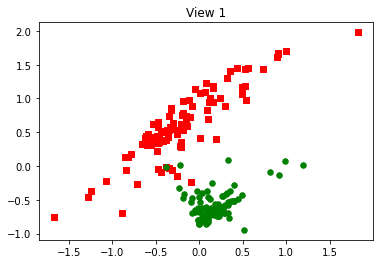

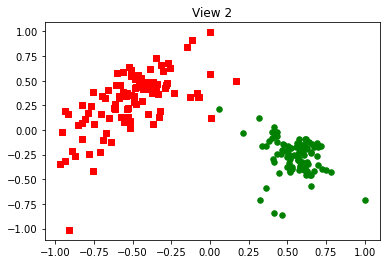

D:\Anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:81: UserWarning: The following kwargs were not used by contour: 'linestyle'


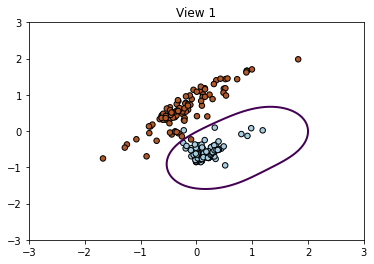

D:\Anaconda\envs\Pytorch\lib\site-packages\ipykernel_launcher.py:81: UserWarning: The following kwargs were not used by contour: 'linestyle'


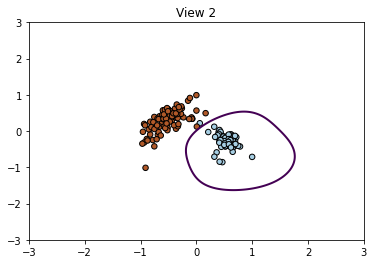

In [8]:
if __name__ == '__main__':

    device = torch.device('cpu')
    
    # 输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 2
    input_shape2 = 10

    # 网络架构设置
    layer_sizes1 = [20, 40, 20, outdim_size]
    layer_sizes2 = [20, 40, 20, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 2000
    reg_par = 1e-5
    use_all_singular_values = False

    # 搭建网络
    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    solver = Solver(model, outdim_size, epoch_num, learning_rate, reg_par, device=device)
    
    # 训练
    train1, train2 = X1, X2
    solver.fit(train1, train2)

    # 测试
    loss, outputs = solver.test(train1, train2)
    
    print("\n**********单独在原始数据集上训练LR和SVM分类器的精度和AUC*************")
    print("View 1(LR) ACC : ", LR_2(X1, y)[0] * 100, "%       AUC:", LR_2(X1, y)[1])
    print("View 2(LR) ACC : ", LR_2(X2, y)[0] * 100, "%       AUC:", LR_2(X2, y)[1])
    print("View 1(SVM) ACC : ", svm_2(X1, y)[0] * 100, "%       AUC:", svm_2(X1, y)[1])
    print("View 2(SVM) ACC : ", svm_2(X2, y)[0] * 100, "%       AUC:", svm_2(X2, y)[1], "\n")
    
    print("**********在抽取出的共同空间上训练LR和SVM分类器的精度和AUC*************")
    print("View 1(LR) ACC : ", LR_2(outputs[0], y)[0] * 100, "%       AUC:", LR_2(outputs[0], y)[1])
    print("View 2(LR) ACC : ", LR_2(outputs[1], y)[0] * 100, "%       AUC:", LR_2(outputs[1], y)[1])
    print("View 1(SVM) ACC : ", svm_2(outputs[0], y)[0] * 100, "%       AUC:", svm_2(outputs[0], y)[1])
    print("View 2(SVM) ACC : ", svm_2(outputs[1], y)[0] * 100, "%       AUC:", svm_2(outputs[1], y)[1])

    #可视化映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y, 'View 1')
    visualization_LR(outputs[1], y, 'View 2')
    visualization_SVM(outputs[0], y, 'View 1')
    visualization_SVM(outputs[1], y, 'View 2')
    

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
data = pd.read_csv("UCI_Credit_Card.csv")
data.isnull().sum()
y = data['default.payment.next.month']
x_ori = data.drop(['ID', 'default.payment.next.month'], axis=1)
x_ori = x_ori.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
x_ori.shape

train_a1 = np.array(x_ori.iloc[:, 0:11])
train_b1 = np.array(x_ori.iloc[:, 11:23])


train_a = torch.from_numpy(train_a1).double()
train_b = torch.from_numpy(train_b1).double()
train_a1.shape

(30000, 11)

In [ ]:
X1 = torch.from_numpy(train_a1).double()
X2 = torch.from_numpy(train_b1).double()


if __name__ == '__main__':

    device = torch.device('cpu')
    
    # 输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 11
    input_shape2 = 12

    # 网络架构设置
    layer_sizes1 = [25, 50, 25, outdim_size]
    layer_sizes2 = [25, 50, 25, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 5000
    reg_par = 1e-5
    use_all_singular_values = False

    # 搭建网络
    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    solver = Solver(model, outdim_size, epoch_num, learning_rate, reg_par, device=device)
    
    # 训练
    train1, train2 = X1, X2
    solver.fit(train1, train2)

    # 测试
    loss, outputs = solver.test(train1, train2)
    
    print("\n**********单独在原始数据集上训练LR和SVM分类器的精度和AUC*************")
    print("View 1(LR) ACC : ", LR_2(X1, y)[0] * 100, "%       AUC:", LR_2(X1, y)[1])
    print("View 2(LR) ACC : ", LR_2(X2, y)[0] * 100, "%       AUC:", LR_2(X2, y)[1])
    print("View 1(SVM) ACC : ", svm_2(X1, y)[0] * 100, "%       AUC:", svm_2(X1, y)[1])
    print("View 2(SVM) ACC : ", svm_2(X2, y)[0] * 100, "%       AUC:", svm_2(X2, y)[1], "\n")
    
    print("**********在抽取出的共同空间上训练LR和SVM分类器的精度和AUC*************")
    print("View 1(LR) ACC : ", LR_2(outputs[0], y)[0] * 100, "%       AUC:", LR_2(outputs[0], y)[1])
    print("View 2(LR) ACC : ", LR_2(outputs[1], y)[0] * 100, "%       AUC:", LR_2(outputs[1], y)[1])
    print("View 1(SVM) ACC : ", svm_2(outputs[0], y)[0] * 100, "%       AUC:", svm_2(outputs[0], y)[1])
    print("View 2(SVM) ACC : ", svm_2(outputs[1], y)[0] * 100, "%       AUC:", svm_2(outputs[1], y)[1])
    
    #可视化映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y, 'View 1')
    visualization_LR(outputs[1], y, 'View 2')
    visualization_SVM(outputs[0], y, 'View 1')
    visualization_SVM(outputs[1], y, 'View 2')


cpu
Epoch: 1     Loss: -0.3917498652526248
Epoch: 2     Loss: -0.5031756282132873
Epoch: 3     Loss: -0.6317604030164718
Epoch: 4     Loss: -0.7109587732558
Epoch: 5     Loss: -0.7545094786370485
Epoch: 6     Loss: -0.7860047237100494
Epoch: 7     Loss: -0.8166102507595961
Epoch: 8     Loss: -0.8411534837978689
Epoch: 9     Loss: -0.8623155591127245
Epoch: 10     Loss: -0.8810589617355122
Epoch: 11     Loss: -0.8975566675687978
Epoch: 12     Loss: -0.9122053865910152
Epoch: 13     Loss: -0.9253382292093459
Epoch: 14     Loss: -0.93722178530089
Epoch: 15     Loss: -0.9480238172240764
Epoch: 16     Loss: -0.9577653081462254
Epoch: 17     Loss: -0.9656112990367298
Epoch: 18     Loss: -0.9706460523000092
Epoch: 19     Loss: -0.9776728384924949
Epoch: 20     Loss: -0.9854093763046643
Epoch: 21     Loss: -0.9929399890109962
Epoch: 22     Loss: -1.0002328080051586
Epoch: 23     Loss: -1.0072271270369246
Epoch: 24     Loss: -1.0136360745395445
Epoch: 25     Loss: -1.0186215890301713
Epoch: 26 

Epoch: 205     Loss: -1.3598804932473787
Epoch: 206     Loss: -1.3606067869233682
Epoch: 207     Loss: -1.3613311257030143
Epoch: 208     Loss: -1.3620472203119773
Epoch: 209     Loss: -1.3627588828102772
Epoch: 210     Loss: -1.3634581013123488
Epoch: 211     Loss: -1.3641511085992242
Epoch: 212     Loss: -1.3648270906326847
Epoch: 213     Loss: -1.3655066492197954
Epoch: 214     Loss: -1.3661728212054938
Epoch: 215     Loss: -1.3668562960993085
Epoch: 216     Loss: -1.3675314864257644
Epoch: 217     Loss: -1.3682155453022715
Epoch: 218     Loss: -1.3688868953576887
Epoch: 219     Loss: -1.3695543893615223
Epoch: 220     Loss: -1.3702084174791196
Epoch: 221     Loss: -1.3708660440931852
Epoch: 222     Loss: -1.3715273809865056
Epoch: 223     Loss: -1.3721930425966429
Epoch: 224     Loss: -1.3728613553854332
Epoch: 225     Loss: -1.3735247228438232
Epoch: 226     Loss: -1.3741876728379359
Epoch: 227     Loss: -1.374841839753824
Epoch: 228     Loss: -1.3754956999967665
Epoch: 229     Lo

Epoch: 406     Loss: -1.4583855616767738
Epoch: 407     Loss: -1.4587282156383408
Epoch: 408     Loss: -1.4590713076802788
Epoch: 409     Loss: -1.4594122157491136
Epoch: 410     Loss: -1.4597530735554822
Epoch: 411     Loss: -1.4600923927416627
Epoch: 412     Loss: -1.46043135339215
Epoch: 413     Loss: -1.4607692602982028
Epoch: 414     Loss: -1.461106629684323
Epoch: 415     Loss: -1.4614432006154232
Epoch: 416     Loss: -1.461779124583568
Epoch: 417     Loss: -1.4621143101165768
Epoch: 418     Loss: -1.4624487733234188
Epoch: 419     Loss: -1.4627824395468099
Epoch: 420     Loss: -1.4631153286993677
Epoch: 421     Loss: -1.4634473077787127
Epoch: 422     Loss: -1.463778467261339
Epoch: 423     Loss: -1.4641085796141062
Epoch: 424     Loss: -1.4644378209833075
Epoch: 425     Loss: -1.4647658390931089
Epoch: 426     Loss: -1.4650928631715288
Epoch: 427     Loss: -1.4654183411334056
Epoch: 428     Loss: -1.4657424644017185
Epoch: 429     Loss: -1.4660642571195521
Epoch: 430     Loss: 

Epoch: 607     Loss: -1.5111685484448885
Epoch: 608     Loss: -1.5113738031090527
Epoch: 609     Loss: -1.5115784129084502
Epoch: 610     Loss: -1.5117820907975408
Epoch: 611     Loss: -1.5119855809601002
Epoch: 612     Loss: -1.512187610100815
Epoch: 613     Loss: -1.5123900238639347
Epoch: 614     Loss: -1.5125906465437204
Epoch: 615     Loss: -1.512792246073137
Epoch: 616     Loss: -1.5129920418431453
Epoch: 617     Loss: -1.5131932030269302
Epoch: 618     Loss: -1.513392787139053
Epoch: 619     Loss: -1.513593709715567
Epoch: 620     Loss: -1.5137932585791523
Epoch: 621     Loss: -1.5139937881583831
Epoch: 622     Loss: -1.5141929723921461
Epoch: 623     Loss: -1.5143926456523038
Epoch: 624     Loss: -1.5145907624945676
Epoch: 625     Loss: -1.5147887748026414
Epoch: 626     Loss: -1.5149845821558607
Epoch: 627     Loss: -1.5151796488195421
Epoch: 628     Loss: -1.5153714546717956
Epoch: 629     Loss: -1.5155627300374348
Epoch: 630     Loss: -1.515750885808159
Epoch: 631     Loss: 

Epoch: 808     Loss: -1.5449387087729975
Epoch: 809     Loss: -1.5450813269735968
Epoch: 810     Loss: -1.5452223509977174
Epoch: 811     Loss: -1.5453634768115292
Epoch: 812     Loss: -1.5455010603377464
Epoch: 813     Loss: -1.5456401246950686
Epoch: 814     Loss: -1.5457754206289
Epoch: 815     Loss: -1.5459141682079407
Epoch: 816     Loss: -1.5460512877341637
Epoch: 817     Loss: -1.546190383245595
Epoch: 818     Loss: -1.5463282064160535
Epoch: 819     Loss: -1.5464672971685944
Epoch: 820     Loss: -1.5466055178511648
Epoch: 821     Loss: -1.5467441746114505
Epoch: 822     Loss: -1.5468822016689963
Epoch: 823     Loss: -1.5470202146652274
Epoch: 824     Loss: -1.5471578564478514


In [ ]:
#Give Me Some Credit
df = pd.read_csv("cs-training.csv")
df = df.drop("Unnamed: 0", axis=1) # drop id column
df = df.loc[df["DebtRatio"] <= df["DebtRatio"].quantile(0.975)]
df = df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] >= 0) & (df["RevolvingUtilizationOfUnsecuredLines"] < 13)]
df = df.loc[df["NumberOfTimes90DaysLate"] <= 17]
dependents_mode = df["NumberOfDependents"].mode()[0]
df["NumberOfDependents"] = df["NumberOfDependents"].fillna(dependents_mode)
income_median = df["MonthlyIncome"].median()
df["MonthlyIncome"] = df["MonthlyIncome"].fillna(income_median)
X = df.drop("SeriousDlqin2yrs", axis=1)
Y = df["SeriousDlqin2yrs"]
train_a1 = np.array(X.iloc[:, 0:5])
train_b1 = np.array(X.iloc[:, 5:10])

y = numpy.array(Y)
train_a1.shape

In [ ]:
X1 = torch.from_numpy(train_a1).double()
X2 = torch.from_numpy(train_b1).double()


if __name__ == '__main__':

    device = torch.device('cpu')
    
    # 输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 5
    input_shape2 = 5

    # 网络架构设置
    layer_sizes1 = [20, 40, 20, outdim_size]
    layer_sizes2 = [20, 40, 20, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 1500
    reg_par = 1e-5
    use_all_singular_values = False

    # 搭建网络
    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    solver = Solver(model, outdim_size, epoch_num, learning_rate, reg_par, device=device)
    
    # 训练
    train1, train2 = X1, X2
    solver.fit(train1, train2)

    # 测试
    loss, outputs = solver.test(train1, train2)
    
    print("**********单独在原始数据集上训练LR和SVM分类器的精度和AUC*************") 
    print("View 1(LR) ACC : ", LR_2(X1, y)[0] * 100, "%       AUC:", LR_2(X1, y)[1])
    print("View 2(LR) ACC : ", LR_2(X2, y)[0] * 100, "%       AUC:", LR_2(X2, y)[1])
    print("View 1(SVM) ACC : ", svm_2(X1, y)[0] * 100, "%       AUC:", svm_2(X1, y)[1])
    print("View 2(SVM) ACC : ", svm_2(X2, y)[0] * 100, "%       AUC:", svm_2(X2, y)[1])
    
    print("**********在抽取出的共同空间上训练LR和SVM分类器的精度和AUC*************")
    print("View 1(LR) ACC : ", LR_2(outputs[0], y)[0] * 100, "%       AUC:", LR_2(outputs[0], y)[1])
    print("View 2(LR) ACC : ", LR_2(outputs[1], y)[0] * 100, "%       AUC:", LR_2(outputs[1], y)[1])
    print("View 1(SVM) ACC : ", svm_2(outputs[0], y)[0] * 100, "%       AUC:", svm_2(outputs[0], y)[1])
    print("View 2(SVM) ACC : ", svm_2(outputs[1], y)[0] * 100, "%       AUC:", svm_2(outputs[1], y)[1])
    
    #可视化映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y, 'View 1')
    visualization_LR(outputs[1], y, 'View 2')
    visualization_SVM(outputs[0], y, 'View 1')
    visualization_SVM(outputs[1], y, 'View 2')


In [ ]:
import os
import struct
import numpy as np
  
def load_mnist_train():
  labels_path = "train-labels.idx1-ubyte"
   
  images_path = "train-images.idx3-ubyte"
   
  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    labels = np.fromfile(lbpath,dtype=np.uint8) 
  
  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
  return images, labels

def load_mnist_test():
  labels_path = "t10k-labels.idx1-ubyte"
   
  images_path = "t10k-images.idx3-ubyte"
   
  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II',lbpath.read(8))
    labels = np.fromfile(lbpath,dtype=np.uint8) 
  
  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
    images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
  return images, labels

train_temp = load_mnist_train()[0]
y = load_mnist_train()[1] % 2

train_a1 = np.array(train_temp[:, 0:392])
train_b1 = np.array(train_temp[:, 392:784])

train_a1.shape


In [ ]:
X1 = torch.from_numpy(train_a1).double()
X2 = torch.from_numpy(train_b1).double()


if __name__ == '__main__':

    device = torch.device('cpu')
    
    # 输出的维度
    outdim_size = 2

    # 两个view的输入
    input_shape1 = 392
    input_shape2 = 392

    # 网络架构设置
    layer_sizes1 = [512, 1024, 512, outdim_size]
    layer_sizes2 = [512, 1024, 512, outdim_size]

    # 超参数设置
    learning_rate = 1e-3
    epoch_num = 2000
    reg_par = 1e-5
    use_all_singular_values = False

    # 搭建网络
    model = DeepCCA(layer_sizes1, layer_sizes2, input_shape1,
                    input_shape2, outdim_size, use_all_singular_values, device=device).double()
    solver = Solver(model, outdim_size, epoch_num, learning_rate, reg_par, device=device)
    
    # 训练
    train1, train2 = X1, X2
    solver.fit(train1, train2)

    # 测试
    loss, outputs = solver.test(train1, train2)
  
    print("**********单独在原始数据集上训练LR和SVM分类器的精度和AUC*************")   
    print("View 1(LR) ACC : ", LR_2(X1, y)[0] * 100, "%       AUC:", LR_2(X1, y)[1])
    print("View 2(LR) ACC : ", LR_2(X2, y)[0] * 100, "%       AUC:", LR_2(X2, y)[1])
    print("View 1(SVM) ACC : ", svm_2(X1, y)[0] * 100, "%       AUC:", svm_2(X1, y)[1])
    print("View 2(SVM) ACC : ", svm_2(X2, y)[0] * 100, "%       AUC:", svm_2(X2, y)[1])
    
    print("**********在抽取出的共同空间上训练LR和SVM分类器的精度和AUC*************") 
    print("View 1(LR) ACC : ", LR_2(outputs[0], y)[0] * 100, "%       AUC:", LR_2(outputs[0], y)[1])
    print("View 2(LR) ACC : ", LR_2(outputs[1], y)[0] * 100, "%       AUC:", LR_2(outputs[1], y)[1])
    print("View 1(SVM) ACC : ", svm_2(outputs[0], y)[0] * 100, "%       AUC:", svm_2(outputs[0], y)[1])
    print("View 2(SVM) ACC : ", svm_2(outputs[1], y)[0] * 100, "%       AUC:", svm_2(outputs[1], y)[1])
    
    #可视化映射到隐空间中的状态，尾数1代表View 1
    visualization_LR(outputs[0], y, 'View 1')
    visualization_LR(outputs[1], y, 'View 2')
    visualization_SVM(outputs[0], y, 'View 1')
    visualization_SVM(outputs[1], y, 'View 2')
